# Málaga Airbnb Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

In this notebook, I'll follow the CRISP-DM process to analyze Málaga Airbnb homes data and answer the following questions:
- What is the perfect time of year to visit Málaga city ?
- Which neighborhood is more affordable and less crowding ?
- Which features is more involved in predicting price ?   


by separating the notebook into 3 parts and show you the details that drive me to the answers

## Part 1:
<h2>What is the perfect time of year to visit Málaga city ?</h2>

### 1.Gather

In [2]:
calendar_df=pd.read_csv("data/calendar.zip",compression='zip') #Loading calendar data

### 2.Assess

In [3]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2334175 entries, 0 to 2334174
Data columns (total 7 columns):
listing_id        int64
date              object
available         object
price             object
adjusted_price    object
minimum_nights    int64
maximum_nights    int64
dtypes: int64(3), object(4)
memory usage: 124.7+ MB


In [4]:
calendar_df.describe()

,listing_id,minimum_nights,maximum_nights
count,2.334175e+06,2.334175e+06,2.334175e+06
mean,2.637861e+07,4.369014e+00,8.335845e+02
std,1.122482e+07,2.753960e+01,4.675077e+02
min,9.603300e+04,1.000000e+00,1.000000e+00
25%,1.837136e+07,2.000000e+00,3.000000e+02
50%,2.708001e+07,2.000000e+00,1.125000e+03
75%,3.601766e+07,3.000000e+00,1.125000e+03
max,4.262131e+07,1.125000e+03,1.127000e+03


In [5]:
calendar_df.isna().sum()

listing_id        0
date              0
available         0
price             0
adjusted_price    0
minimum_nights    0
maximum_nights    0
dtype: int64

In [6]:
calendar_df.duplicated().sum()

0

### 3.Clean & Analyize

In [7]:
#remove '$' and ',' from price and cast it to float
calendar_df.price=calendar_df.price.apply(lambda x:x[1:].replace(',','')).astype(float)
pd.DataFrame(calendar_df['price'].sample(5))

,price
2291057,90.0
1454512,133.0
36746,50.0
1054938,99.0
2014430,18.0


In [8]:
#change 'date' column type from 'str' to 'datetime'
calendar_df['date']=pd.to_datetime(calendar_df['date'])
pd.DataFrame(calendar_df['date'].sample(5))

,date
2291728,2020-03-06
1557822,2020-03-30
742478,2020-06-28
1217853,2020-10-26
363475,2020-07-09


### 4.Model and Visualize

In [9]:
# Create new columns to split date to year, month, and day
calendar_df['year'] = calendar_df['date'].dt.year
calendar_df['month'] = calendar_df['date'].dt.month
calendar_df['day'] = calendar_df['date'].dt.day

In [10]:
calendar_df.sample(3)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,year,month,day
2038697,39625207,2020-09-12,f,35.0,$32.00,1,30,2020,9,12
1045802,25362217,2020-09-28,t,73.0,$73.00,2,999,2020,9,28
347421,14091245,2020-05-28,t,45.0,$45.00,3,250,2020,5,28


In [11]:
#check values of available column
pd.DataFrame(calendar_df.available.value_counts())

,available
t,1317120
f,1017055


In [12]:
#convert available value from t to 1 and f to 0
calendar_df.available=calendar_df.available.map({'t':1,'f':0})
pd.DataFrame(calendar_df['available'].value_counts())

,available
1,1317120
0,1017055


In [13]:
month_availability=calendar_df.groupby(['month'])['available'].mean().sort_values(ascending=False)
pd.DataFrame(month_availability)

,available
month,
7,0.625312
8,0.619622
5,0.618306
6,0.608314
9,0.604154
10,0.599546
11,0.599364
4,0.541089
12,0.538036


In [14]:
#some stats about month_availability
pd.DataFrame(month_availability.describe())

,available
count,12.000000
mean,0.563760
std,0.062893
min,0.462463
25%,0.523675
50%,0.599455
75%,0.610812
max,0.625312


In [15]:
# I'll consider months with the average amount of available present over 0.61 to be active (above 75% of data)
active_months_val=month_availability[month_availability>0.61]
active_months=active_months_val.index.tolist()
active_months

[7, 8, 5]

In [16]:
# and I'll consider months with the average amount of available present under 0.52 to be inactive (below 25% of data)
inactive_months_val=month_availability[month_availability<0.523]

# Get names of active months
inactive_months=inactive_months_val.index.tolist()
inactive_months

[1, 2, 3]

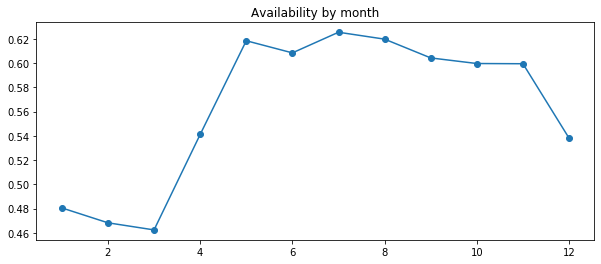

In [17]:
#Plot Availability by month
plt.figure(figsize=(10,4))
plt.plot(month_availability.sort_index(), 'o-')
plt.title('Availability by month')
plt.show()

- Based on the above graph:
    - May, July, and August are the most available time of the year to visit Malaga city.
    - January, February and March are the least.

But what about days let's try to explore it

#### I. Active Days

In [18]:
# Separate the active months in another dataframe
active_months_df=calendar_df[calendar_df['month'].isin(active_months)] 

# Count of availability for each day
active_months_available_days=active_months_df.groupby(['day'])['available'].mean().sort_values(ascending=False)
pd.DataFrame(active_months_available_days)

,available
day,
27,0.659004
26,0.658952
25,0.652906
24,0.646547
12,0.636800
28,0.635757
13,0.632317
31,0.632004
23,0.631691


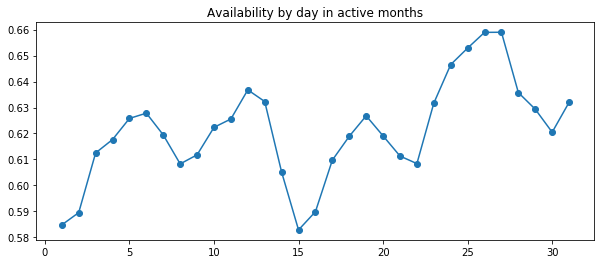

In [19]:
#Plot Availability by Day in active months
plt.figure(figsize=(10,4))
plt.plot(active_months_available_days.sort_index(), 'o-')
plt.title('Availability by day in active months')
plt.show()

#### II. Inactive Days

In [20]:
# Separate the inactive months in another dataframe
inactive_months_df=calendar_df[calendar_df['month'].isin(inactive_months)] 

# Count of availability for each day
inactive_months_available_days=inactive_months_df.groupby(['day'])['available'].mean().sort_values(ascending=False)
pd.DataFrame(inactive_months_available_days)

,available
day,
31,0.526349
30,0.517748
29,0.505395
24,0.499661
25,0.496846
23,0.495856
17,0.489653
26,0.489601
10,0.488350


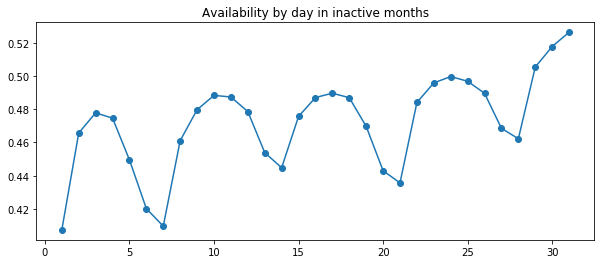

In [21]:
#Plot Availability by Day in inactive months
plt.figure(figsize=(10,4))
plt.plot(inactive_months_available_days.sort_index(), 'o-')
plt.title('Availability by day in inactive months')
plt.show()

All the above exploring was about availability but what about price let's take it a look

In [22]:
# Average price per months
month_price=calendar_df.groupby(['month'])['price'].mean().sort_values(ascending=False)
pd.DataFrame(month_price)

,price
month,
2,407.867346
1,382.065429
12,164.219108
9,156.181324
10,150.027264
11,147.509950
8,146.121547
7,124.526354
6,110.661704


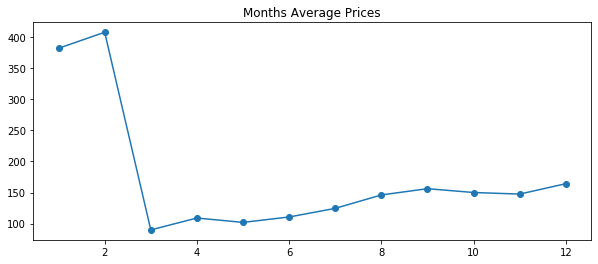

In [23]:
plt.figure(figsize=(10,4))
plt.title('Months Average Prices')
plt.plot(month_price.sort_index(), 'o-');

In [24]:
# Get statistical information
pd.DataFrame(month_price.describe())

,price
count,12.000000
mean,174.163595
std,105.920524
min,89.849106
25%,110.243410
50%,146.815749
75%,158.190770
max,407.867346


In [25]:
# Consider months with avergae price over 158 to be expensive (above 75% of data)
high_price_months=month_price[month_price>158]

# Get names of high price months
expensive_months=high_price_months.index.tolist()
expensive_months

[2, 1, 12]

In [26]:
# Consider months with avergae price over 110 to be expensive (less 25% of data)
low_price_months=month_price[month_price<110]

# Get names of high price months
cheap_months=low_price_months.index.tolist()
cheap_months

[4, 5, 3]

- Based on the above analyzing:
    - Prices increase in Winter season, mostly in December, January and February
    - Prices decrease in Spring season in March, April and May
    
So we can apply some rules to get the best time to visit Malaga:

In [27]:
# Get active and expensive months
print("Active and expensive months :",list(set(expensive_months) & set(active_months)))
# Get inactive and expensive months
print("Inactive and expensive months :",list(set(expensive_months) & set(inactive_months)))
# Get active and cheap months
print("Active and cheap months :",list(set(cheap_months) & set(active_months)))
# Get inactive and cheap months
print("Inactive and cheap months :",list(set(cheap_months) & set(inactive_months)))

Active and expensive months : []
Inactive and expensive months : [1, 2]
Active and cheap months : [5]
Inactive and cheap months : [3]


#### In Conclusion
"March is the less crowded and most affordable time in year to visit Malaga"

## Part 2:
<h2>Which neighborhood is more affordable and less crowding ?</h2>

### 1.Gather

In [28]:
#load listings data with just used columns
listings_df = pd.read_csv('data/listings.zip',compression='zip',usecols=['id','neighbourhood','price'])
listings_df.sample(5)

,id,neighbourhood,price
2774,24926702,Centro,69
3865,31646315,Centro,95
5156,37543860,Campanillas,165
5205,37697878,Centro,106
3924,32007219,Este,100


### 2.Assess

In [29]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6395 entries, 0 to 6394
Data columns (total 3 columns):
id               6395 non-null int64
neighbourhood    6395 non-null object
price            6395 non-null int64
dtypes: int64(2), object(1)
memory usage: 150.0+ KB


In [30]:
listings_df.describe()

,id,price
count,6.395000e+03,6395.000000
mean,2.637861e+07,99.360751
std,1.122570e+07,362.736830
min,9.603300e+04,10.000000
25%,1.837153e+07,48.000000
50%,2.708001e+07,65.000000
75%,3.601457e+07,95.000000
max,4.262131e+07,15000.000000


### 3.Clean & Analyize

In [31]:
listings_df.isna().sum()

id               0
neighbourhood    0
price            0
dtype: int64

In [32]:
listings_df.duplicated().sum()

0

as we see the data havn't null or dupicated rows and data types is as expected

### 4.Model & Visualize

#### I.Price

In [33]:
# Average price for each neighbourhood group
neighbourhood_price=listings_df.groupby(['neighbourhood'])['price'].mean()

# Sort values in descending order
neighbourhood_price=neighbourhood_price.sort_values(ascending=False)
pd.DataFrame(neighbourhood_price)

,price
neighbourhood,
Churriana,119.829787
Centro,104.956950
Este,102.696124
Puerto de la Torre,99.289474
Carretera de Cadiz,87.034111
Teatinos-Universidad,86.444444
Palma-Palmilla,78.043478
Campanillas,77.500000
Cruz De Humilladero,73.524430


In [34]:
# get stats info
pd.DataFrame(neighbourhood_price.describe())

,price
count,11.000000
mean,85.170850
std,20.921637
min,48.449438
25%,75.512215
50%,86.444444
75%,100.992799
max,119.829787


In [35]:
# Consider neighbourhood with avergae price over 101 to be expensive (above 75% of data)
high_price_neighbourhood_val=neighbourhood_price[neighbourhood_price>101]

# Get names of high price neighbourhoods
expensive_neighbourhoods=high_price_neighbourhood_val.index.tolist()
expensive_neighbourhoods

['Churriana', 'Centro', 'Este']

In [36]:
# Consider neighbourhood with avergae price less tahn 75 to be expensive (under 25% of data)
low_price_neighbourhood_val=neighbourhood_price[neighbourhood_price<75]

# Get names of high price neighbourhoods
cheap_neighbourhoods=low_price_neighbourhood_val.index.tolist()
cheap_neighbourhoods

['Cruz De Humilladero', 'Ciudad Jardin', 'Bailen-Miraflores']

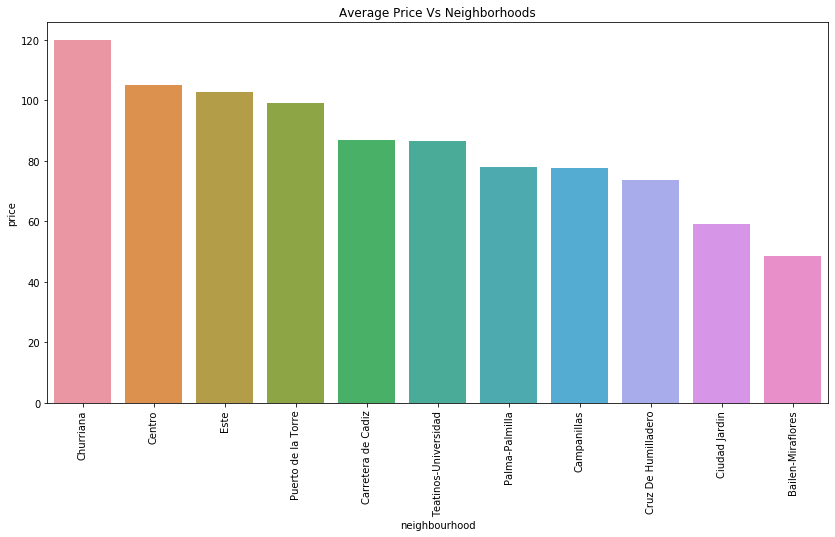

In [37]:
# Plot the average price per neighbourhoods
plt.figure(figsize=(14,7))
plt.xticks(rotation=90)
plt.xlabel('Neighborhoods')
plt.ylabel('Price')
plt.title('Average Price Vs Neighborhoods')
sns.barplot(neighbourhood_price.index,neighbourhood_price);

- Based on the above analysis,
    - Churriana, Centro and  Este are the most expensive.
    - Cruz De Humilladero, Ciudad Jardin and Bailen-Miraflores are the cheapest.

#### II. Popularity

In [38]:
# The average number of listings for each neighbourhood group
neighbourhoods_popularity=listings_df.groupby(['neighbourhood'])['id'].mean()

# Sort values in descending order
neighbourhoods_popularity=neighbourhoods_popularity.sort_values(ascending=False)
pd.DataFrame(neighbourhoods_popularity)

,id
neighbourhood,
Campanillas,3.118646e+07
Cruz De Humilladero,2.948411e+07
Ciudad Jardin,2.850531e+07
Palma-Palmilla,2.743593e+07
Churriana,2.736920e+07
Bailen-Miraflores,2.704404e+07
Carretera de Cadiz,2.689461e+07
Centro,2.639207e+07
Este,2.436559e+07


In [39]:
# get stats info
pd.DataFrame(neighbourhoods_popularity.describe())

,id
count,1.100000e+01
mean,2.686464e+07
std,2.434618e+06
min,2.311272e+07
25%,2.537883e+07
50%,2.704404e+07
75%,2.797062e+07
max,3.118646e+07


In [40]:
# Consider neighbourhood with The average number of listings over 2.797062e+07 to be popular (above 75% of data)
pop_neighbourhood_val=neighbourhoods_popularity[neighbourhoods_popularity>2.797062e+07]

# Get names of high price months
pop_neighbourhood=pop_neighbourhood_val.index.tolist()
pop_neighbourhood

['Campanillas', 'Cruz De Humilladero', 'Ciudad Jardin']

In [41]:
# Consider neighbourhood with The average number of listings less than 2.537883e+07 to be popular (less 25% of data)
unpop_neighbourhood_val=neighbourhoods_popularity[neighbourhoods_popularity<2.537883e+07]

# Get names of high price months
unpop_neighbourhood=unpop_neighbourhood_val.index.tolist()
unpop_neighbourhood

['Este', 'Puerto de la Torre', 'Teatinos-Universidad']

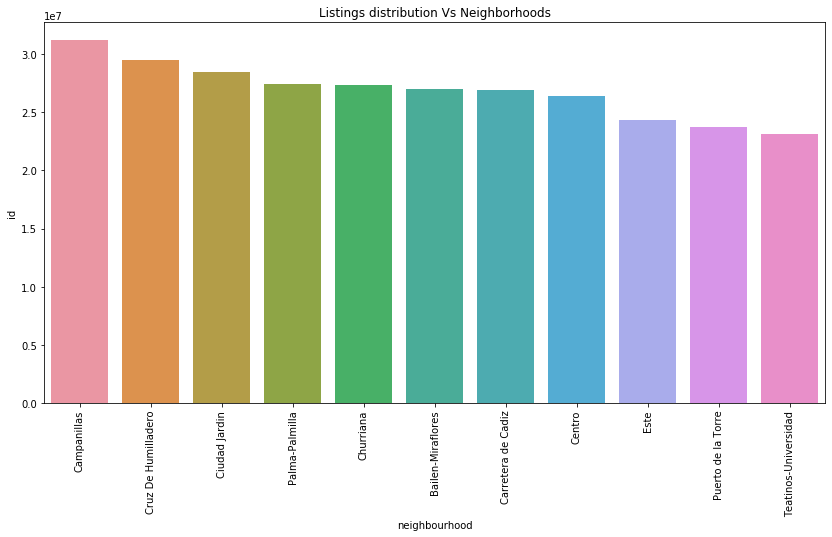

In [42]:
# Plot the average price per neighbourhoods
plt.figure(figsize=(14,7))
plt.xticks(rotation=90)
plt.xlabel('Neighborhoods')
plt.ylabel('Average number of listings')
plt.title('Listings distribution Vs Neighborhoods')
sns.barplot(neighbourhoods_popularity.index,neighbourhoods_popularity);

- Based on the above graph,
    - Campanillas, Cruz De Humilladero and Ciudad Jardin are the most crowded neighbourhoods.
    - Este, Puerto de la Torre and Teatinos-Universidad are the least crowded neighbourhoods.
    
So we can apply some rules to get the best neighbourhoods to accommodate in:

In [43]:
# Get expensive and crowded neighbourhoods
print("Expensive and crowded neighbourhood :",list(set(expensive_neighbourhoods) & set(pop_neighbourhood)))
# Get expensive and less crowded neighbourhoods
print("Expensive and less crowded neighbourhood :",list(set(expensive_neighbourhoods) & set(unpop_neighbourhood_val)))
# Get cheap and crowded neighbourhoods
print("Cheap and crowded neighbourhood :",list(set(cheap_neighbourhoods) & set(pop_neighbourhood)))
# Get cheap and less crowded neighbourhoods
print("Cheap and less crowded neighbourhood :",list(set(cheap_neighbourhoods) & set(unpop_neighbourhood)))

Expensive and crowded neighbourhood : []
Expensive and less crowded neighbourhood : []
Cheap and crowded neighbourhood : ['Ciudad Jardin', 'Cruz De Humilladero']
Cheap and less crowded neighbourhood : []


- In Conclusion,
    - The expensive neighbourhoods has a medium crowding (not extreme crowded or of the most less neighbourhoods)
    - Ciudad Jardin, Cruz De Humilladero and is the cheapest but they are crowded so you have to sacrifice with adapting with crowding if you want to save some money.